# Sleep Overall Score Model Multiple Files
Training a model to predict energy next day from sleep.

In [1]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import run_yasa
import logging
import mne
import yasa
import os
import argparse
import os

import mne
import numpy as np
import pandas as pd
from brainflow.board_shim import BoardShim, BoardIds
from brainflow.data_filter import DataFilter
log = lambda msg: logging.info(msg)

pd.set_option('display.max_columns', 100)


# Load data

In [2]:
input_dir = "C:\\dev\\play\\brainwave-data"
stats_df = pd.read_csv(input_dir + os.path.sep + "stats.csv")


In [3]:
from sleep_events import load_days_data

day_data = load_days_data(True)

In [4]:
result_df = day_data.copy()
target_col = "energy:energyScore"

In [5]:
[col for col in result_df.columns if 'energy' in col]

['energy',
 'energy:energyScore',
 'energy:energyScoreScaled',
 'energy:aggregated:manualDayEnergyScoreStartToEvening',
 'energy:aggregated:manualDayEnergyScoreFromMiddayUntilEvening',
 'energy:manualDayEnergyScoreFromStartUntilMidday',
 'energy:aggregated:manualDayEnergyScoreFromEvening']

In [6]:
result_df["energy:energyScore"].describe()

count     85.000000
mean      41.604875
std       29.122702
min       10.000000
25%       20.000000
50%       28.240741
75%       50.000000
max      120.000000
Name: energy:energyScore, dtype: float64

# Prepare data

In [30]:
from memory import garbage_collect
from dataclasses import dataclass
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder as SklearnOneHotEncoder
import pandas as pd
import json


import pandas as pd
import numpy as np
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline

# Custom Transformer to remove highly correlated percentile columns
class RemoveHighlyCorrelatedColumns(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.97):
        self.threshold = threshold
        self.columns_to_remove_ = []

    def fit(self, X, y=None):
        # Iterate through each column in X
        for col in X.columns:
            # Replace "percentile90" or "percentile10" with "mean"
            new_col = col.replace('percentile90', 'mean').replace('percentile10', 'mean')

            # Check if the new "mean" column exists and it's not the same as the original column
            if new_col in X.columns and col != new_col:
                # Calculate the correlation
                correlation = X[col].corr(X[new_col])

                # If correlation is greater than or equal to the threshold, mark the column for removal
                if correlation >= self.threshold:
                    self.columns_to_remove_.append(col)

        return self

    def transform(self, X, y=None):
        # Drop the columns that are highly correlated with their corresponding mean columns
        return X.drop(columns=self.columns_to_remove_, errors='ignore')


class RowsWithTargetCol(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return result_df[~result_df['energy:energyScore'].isna()]


class DropAllEnergyCols(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        useful_features = [col for col in X.columns if (target_col == col or 'energy' not in col)]
        return X[useful_features]


class DropFlakyCols(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        useful_features = [col for col in X.columns if (target_col == col or 'presence:' not in col)]
        return X[useful_features]
    
class DropNonEEGDataIfNeeded(BaseEstimator, TransformerMixin):
    def __init__(self, target_col, sources: list[str]):
        self.target_col = target_col
        self.sources = sources

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        need_eeg = "eeg" in self.sources or "eeg_deep" in self.sources or "only_sleep_score_features" in self.sources
        if need_eeg:
            return X[X['night:yasaExtended:All:sdelta_s:mean'].notna()]
        return X



class UsefulFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, target_col, sources: list[str]):
        self.target_col = target_col
        self.sources = sources
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Just not really ready for primetime
        not_ready_for_primetime = ["presence:", "settling:"]
        useless = ["generatedAt", "hasYasa", "morningQuestionnaire"]
        do_not_want_in_model = ["date:", "-M1", "Fpz"]
        # Will want to use adjusted instead
        duplicates = ["night:fitbit:source:", "night:yasa:source:"]
        # Need to debug
        not_present_on_all_rows_for_some_reason = ["SleepHour", "Stability:Aggregated", "TiredVsWired", "BeforeSleep", "ReadyToSleep"]
        remove_list = not_ready_for_primetime + useless + do_not_want_in_model + duplicates + not_present_on_all_rows_for_some_reason
        
        remove_if_includes_list = ["energy"]

        useful_features = [col for col in X.columns \
                           if (self.target_col in col) \
                            # Part of target list
                            #and not 'energy' in col \
                            or not any(rem in col for rem in remove_list)
                           ]
        
        if "eeg_deep" in self.sources:
            useful_features = [col for col in useful_features if ('yasa' in col.lower() and (('deep' in col.lower()) or 'N3' in col)) or self.target_col in col]
        if "eeg" in self.sources:
            useful_features = [col for col in useful_features if ('yasa' in col.lower()) or self.target_col in col]
        if "only_sleep_score_features" in self.sources:
            features = [
                "night:aggregated:totalSleepTimeSecs",
                "night:yasa:adjusted:wakingsWithDurationCount",
                "night:yasaExtended:Sleep:fdelta_s:mean",
                "night:yasaExtended:N3:sdelta_s:mean",
                "night:aggregated:timeAwakeAfterSleepSecs",
                "night:yasa:adjusted:lightSleepSecs",
                "night:yasa:adjusted:remSleepSecs",
                "night:yasaExtended:Sleep:sdeltaabs_s:mean",
                "night:yasaExtended:Sleep:iqr_s:mean",
                "night:yasaExtended:Sleep:theta_s:mean",
                "circadian:combined:entries:NL:temp",
                "night:yasaExtended:N2:skew_s:mean",
                "night:yasaExtended:Sleep:abspow_s:mean",
                "night:yasaExtended:N3:skew_s:mean",
                "night:yasaExtended:SlowWaves:Fpz-M1:ValNegPeak",
                "night:yasaExtended:Stability:Aggregated:N2",
                "night:yasaExtended:Sleep:auc_s:mean"
            ]
            useful_features = [col for col in useful_features if (col in features) or self.target_col in col]
        
        
        
        return X[useful_features]

class DropNaNRows(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Identify rows with NaN values
        nan_rows = X.isna().any(axis=1)

        # Log the indexes of dropped and kept rows
        dropped_indexes = X[nan_rows].index.tolist()
        kept_indexes = X[~nan_rows].index.tolist()

        # Log the first column that had NaN for each dropped row
        reasons = X[nan_rows].apply(lambda row: row[row.isna()].index[0], axis=1).tolist()

        print(f"Dropped row indexes: {dropped_indexes}")
        print(f"Kept row indexes: {kept_indexes}")
        print(f"Reasons for dropping: {reasons}")

        # Drop rows with NaN values
        return X.dropna()    
# Get EEG deep features.  Ignore Fitbit.
class EEGDeepFeatures(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        useful_features = [col for col in X.columns if ('onDayMinus1' in col and 'yasa' in col.lower() and (('deep' in col.lower()) or 'N3' in col)) or target_col in col]
        return X[useful_features]

# Get things that happen before night.
class BeforeNightFeatures(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # We still want thinks the day before, as we are interested in energy next day.
        useful_features = [col for col in X.columns if (('onDayMinus1' in col or target_col in col) and 'night:' not in col)]
        return X[useful_features]


# Drop columns where we don't have much data
class DropFewValidColumns(BaseEstimator, TransformerMixin):
    def __init__(self, min_valid=5):
        self.min_valid = min_valid  # Minimum valid values required to keep the column
        self.columns_to_keep_ = None  # Will store the columns to keep

    def fit(self, X, y=None):
        # Identify columns where the count of non-NaNs is at least min_valid
        valid_counts = X.notna().sum()
        self.columns_to_keep_ = valid_counts[valid_counts >= self.min_valid].index.tolist()
        return self  # Return self to comply with scikit-learn's fit API

    def transform(self, X, y=None):
        # Keep only the identified columns with at least min_valid non-NaNs
        return X[self.columns_to_keep_]


@dataclass
class ModelAndData:
    name: str
    target_col: str
    sources: list[str]
    prepared_df: pd.DataFrame
    X: pd.DataFrame
    y: pd.Series
    model: object = None
    X_train: pd.DataFrame = None
    y_train: pd.Series = None
    X_val: pd.DataFrame = None
    y_val: pd.Series = None


garbage_collect(log)

modelsAndData: list[ModelAndData] = []

def create_and_add(target_col: str, sources: list[str], input):
    name = f"target:{target_col} sources:{sources}"

    pipeline = Pipeline([
        ('rows', RowsWithTargetCol()),
        ('drop_energy', DropAllEnergyCols()),
        ('drop_non_eeg_data_if_needed', DropNonEEGDataIfNeeded(target_col, sources)),
        ('features', UsefulFeatures(target_col, sources)),
        ('drop_nan', DropNaNRows()),
        ('drop_few_values', DropFewValidColumns()),
        ('remove_highly_correlated', RemoveHighlyCorrelatedColumns(threshold=0.97)),
    ])

    prepared_df = pipeline.fit_transform(input)

    X = prepared_df.drop(columns=[target_col])
    # X = prepared_df
    y = prepared_df[target_col]
    # y = prepared_df

    md = ModelAndData(name, target_col, sources, prepared_df, X, y)
    modelsAndData.append(md)


# create_and_add("energy:energyScore", ["all"], result_df)
create_and_add("energy:energyScore", ["eeg"], result_df)
# create_and_add("energy:energyScore", ["only_sleep_score_features"], result_df)
# create_and_add("energy:energyScore", ["eeg_deep"], result_df)
# create_and_add("energy:energyScore", ["before_night"], result_df)


# prepared_df_all_features, X_all_features, y_all_features = pipeline_all_features(result_df)
# prepared_df_eeg_deep, X_eeg_deep, y_eeg_deep = pipeline_eeg_deep(result_df)
# prepared_df_before_night, _, _ = pipeline_before_night(result_df)
# 
# print([col for col in X_all_features.columns if ('energy' in col.lower())])
# print([col for col in X_eeg_deep.columns if ('energy' in col.lower())])
# print(len(result_df.columns))
# print(len(prepared_df_all_features.columns))
# print(len(prepared_df_eeg_deep.columns))
# print(len(prepared_df_before_night.columns))
modelsAndData[0].X.describe()

Dropped row indexes: [151, 158]
Kept row indexes: [81, 82, 92, 97, 120, 121, 122, 124, 133, 134, 135, 136, 137, 143, 145, 147, 149, 152, 156, 157, 160, 162, 163, 164, 166, 167, 169, 173, 185, 186, 192, 194, 195, 197, 198, 209, 214, 216, 218, 221, 222, 223, 229]
Reasons for dropping: ['night:yasaExtended:N1:thetaabsab_s:mean', 'night:yasa:adjusted:readyToSleepTimeSSM']


,night:yasaExtended:Sleep:fdelta_s:mean,night:yasaExtended:N1:thetaabsab_s:mean,night:yasaExtended:R:perm_s:mean,night:yasaExtended:N2:db_s:mean,night:yasaExtended:Sleep:spectral_centroid_s:mean,night:yasaExtended:All:fdelta_s:mean,night:yasaExtended:N2:sdelta_s:mean,night:yasaExtended:All:higuchi_s:mean,night:yasaExtended:R:sigmaabsab_s:mean,night:yasaExtended:SlowWaves:Aggregated:Slope,night:yasaExtended:R:betaabs_s:mean,night:yasaExtended:All:alphaabsab_s:mean,night:yasaExtended:N1:alphaaa_s:mean,night:yasaExtended:All:spectral_centroid_s:mean,night:yasaExtended:N2:fdeltaabs_s:mean,night:yasaExtended:W:abspow_s:mean,night:yasaExtended:N1:hcomp_s:mean,night:yasaExtended:N2:thetaabsaa_s:mean,night:yasaExtended:N2:ds_s:mean,night:yasaExtended:N2:thetaaa_s:mean,night:yasaExtended:N2:higuchi_s:mean,night:yasaExtended:R:thetaabsab_s:mean,night:yasaExtended:N2:abspow_s:mean,night:yasaExtended:Statistics:Lat_N2,night:yasaExtended:N3:higuchi_s:mean,night:yasaExtended:Sleep:alphaabsaa_s:mean,night:yasaExtended:All:fdeltaabs_s:mean,night:yasaExtended:All:kurt_s:mean,night:yasaExtended:Statistics:N3,night:yasaExtended:R:auc_s:mean,night:yasaExtended:N3:kurt_s:mean,night:yasaExtended:NREM:fdeltaab_s:mean,night:yasaExtended:All:sigma_s:mean,night:yasaExtended:R:alphaabsaa_s:mean,night:yasaExtended:N1:thetaaa_s:mean,night:yasaExtended:NREM:theta_s:mean,night:yasaExtended:R:fdelta_s:mean,night:yasaExtended:N1:spectral_centroid_s:mean,night:yasaExtended:All:auc_s:mean,night:yasaExtended:All:nzc_s:mean,night:yasaExtended:W:thetaab_s:mean,night:yasaExtended:N3:sigmaabsaa_s:mean,night:yasaExtended:All:alphaaa_s:mean,night:yasaExtended:N1:sdelta_s:mean,night:yasaExtended:All:iqr_s:mean,night:yasaExtended:N3:iqr_s:mean,night:yasaExtended:N1:sigmaabsaa_s:mean,night:yasaExtended:W:beta_s:mean,night:yasaExtended:N3:abspow_s:mean,night:yasaExtended:R:higuchi_s:mean,...,night:yasaExtended:W:thetaabsab_s:mean,night:yasaExtended:N3:fdeltaabsab_s:mean,night:yasaExtended:N2:sigmaabsab_s:mean,night:yasaExtended:NREM:fdeltaabsab_s:mean,night:yasaExtended:N1:petrosian_s:mean,night:yasaExtended:NREM:alphaabs_s:mean,night:yasaExtended:N1:thetaabsaa_s:mean,night:yasaExtended:N2:fdelta_s:mean,night:yasaExtended:N3:sdeltaabs_s:mean,night:yasaExtended:W:sigmaabsaa_s:mean,night:yasaExtended:N2:fdeltaabsaa_s:mean,night:yasaExtended:W:std_s:mean,night:yasaExtended:All:fdeltaab_s:mean,night:yasa:adjusted:betweenAsleepAndWakeSecs,night:yasa:adjusted:lightSleepSecs,night:yasaExtended:All:perm_s:mean,night:yasaExtended:NREM:fdeltaabs_s:mean,night:yasaExtended:All:perment_s:mean,night:yasaExtended:N3:specent_s:mean,night:yasaExtended:Sleep:perment_s:mean,night:yasaExtended:R:alpha_s:mean,night:yasaExtended:W:fdeltaabsaa_s:mean,night:yasaExtended:N3:std_s:mean,night:yasa:adjusted:asleepTimeSSM,night:yasaExtended:R:db_s:mean,night:yasaExtended:All:fdeltaabsab_s:mean,night:yasaExtended:N2:thetaabs_s:mean,night:yasaExtended:Sleep:beta_s:mean,night:yasaExtended:All:alphaab_s:mean,night:yasaExtended:N2:fdeltaab_s:mean,night:yasaExtended:NREM:petrosian_s:mean,night:yasaExtended:Statistics:N2,night:yasaExtended:Statistics:SE,night:yasaExtended:NREM:beta_s:mean,night:yasaExtended:W:sigma_s:mean,night:yasaExtended:All:skew_s:mean,night:yasaExtended:R:svdent_s:mean,night:yasaExtended:Statistics:WASO,night:yasaExtended:Sleep:higuchi_s:mean,night:yasaExtended:Sleep:dt_s:mean,night:yasaExtended:W:alphaab_s:mean,night:yasaExtended:Statistics:%N2,night:yasaExtended:Sleep:sigmaabsaa_s:mean,night:yasaExtended:All:thetaab_s:mean,night:yasaExtended:NREM:alphaab_s:mean,night:yasaExtended:SlowWaves:Aggregated:ValPosPeak,night:yasaExtended:N1:alphaabsaa_s:mean,night:yasaExtended:Sleep:sdelta_s:mean,night:yasaExtended:R:fdeltaabsab_s:mean,night:yasaExtended:All:sigmaaa_s:mean
count,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000

In [32]:
modelsAndData[0].X.info()


<class 'pandas.core.frame.DataFrame'>
Index: 43 entries, 81 to 229
Columns: 426 entries, night:yasaExtended:Sleep:fdelta_s:mean to night:yasaExtended:All:sigmaaa_s:mean
dtypes: float64(426)
memory usage: 143.4 KB


In [33]:
import pandas as pd

df = modelsAndData[0].X
nan_counts = df.isna().sum().reset_index()
nan_counts.columns = ['Column', 'NaN Count']

# Calculate the count of not-NaN rows for each column
not_nan_counts = df.notna().sum().reset_index(drop=True)
nan_counts['Not-NaN Count'] = not_nan_counts

nan_counts

,Column,NaN Count,Not-NaN Count
0,night:yasaExtended:Sleep:fdelta_s:mean,0,43
1,night:yasaExtended:N1:thetaabsab_s:mean,0,43
2,night:yasaExtended:R:perm_s:mean,0,43
3,night:yasaExtended:N2:db_s:mean,0,43
4,night:yasaExtended:Sleep:spectral_centroid_s:mean,0,43
...,...,...,...
421,night:yasaExtended:SlowWaves:Aggregated:ValPos...,0,43
422,night:yasaExtended:N1:alphaabsaa_s:mean,0,43
423,night:yasaExtended:Sleep:sdelta_s:mean,0,43
424,night:yasaExtended:R:fdeltaabsab_s:mean,0,43


In [34]:
result_df["energy:energyScore"].describe()

count     85.000000
mean      41.604875
std       29.122702
min       10.000000
25%       20.000000
50%       28.240741
75%       50.000000
max      120.000000
Name: energy:energyScore, dtype: float64

# Train XGBoost model

In [35]:
def train_xgboost(X, y, alpha):
    import pandas as pd
    import xgboost as xgb
    from sklearn.model_selection import KFold, cross_val_score
    from sklearn.metrics import mean_absolute_error
    
    # Initialize the XGBoost model with Lasso-like regularization
    xgboost_model = xgb.XGBRegressor(
        #alpha=alpha,  # L1 regularization term on weights (Lasso)
        # objective='reg:pseudohubererror',
        n_estimators=200,
        max_depth=5,
        learning_rate=0.1,
        alpha=10.0,  # L1 regularization term
        reg_lambda=5.0  # L2 regularization term
    )
    
    # Set up k-fold cross-validation
    # kf = KFold(n_splits=5, shuffle=True, random_state=42)
    # 
    # # Perform cross-validation and evaluate the model using MAE
    # cv_scores = cross_val_score(xgboost_model, X, y, cv=kf, scoring='neg_mean_absolute_error')
    # 
    # # Convert negative MAE to positive
    # cv_scores = -cv_scores
    # 
    # # Print the cross-validation scores and their mean
    # print(f"Cross-validation MAE scores: {cv_scores}")
    # print(f"Mean Cross-validation MAE: {cv_scores.mean()}")
    
    xgboost_model.fit(X, y)
    return xgboost_model

for md in modelsAndData:
# xgboost_model_all_features = train_xgboost(X_all_features, y_all_features)
    md.model = train_xgboost(md.X, md.y, 5)

Evaluation for model:  target:energy:energyScore sources:['eeg']
target:energy:energyScore sources:['eeg'] Training Set Evaluation:
MAE: 0.5827277487127884, MSE: 1.9184692039173576, RMSE: 1.3850881574532927


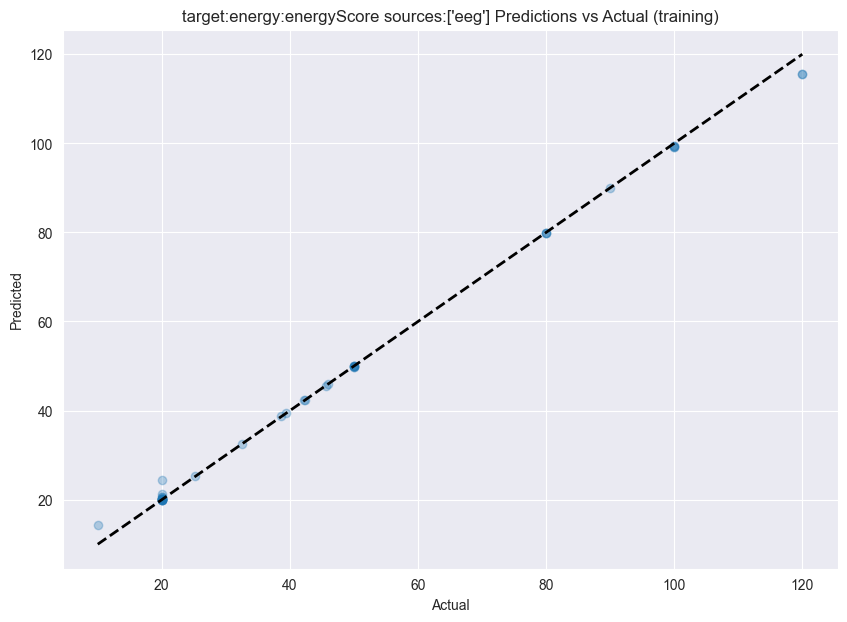

target:energy:energyScore sources:['eeg'] Validation Set Evaluation:
MAE: 0.5827277487127884, MSE: 1.9184692039173576, RMSE: 1.3850881574532927


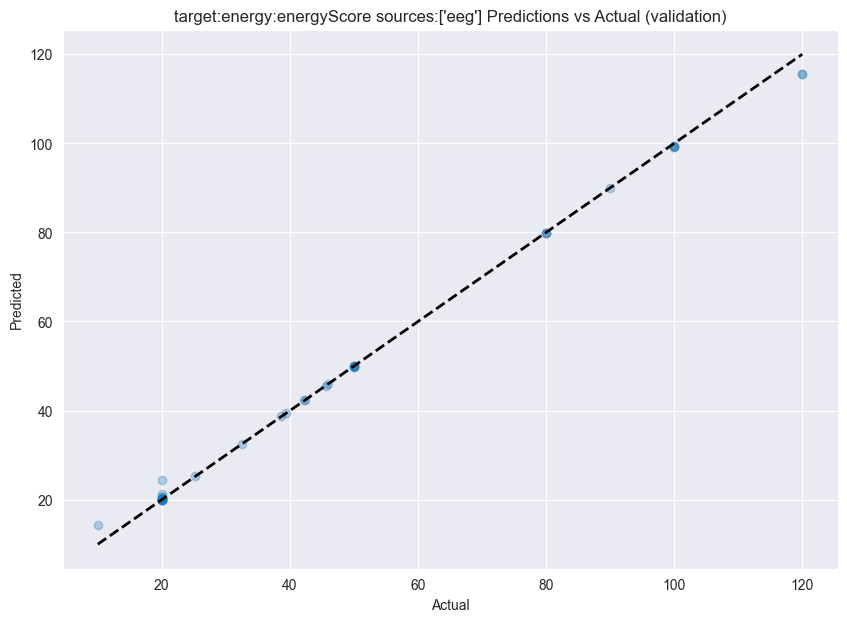

In [36]:
from sklearn.metrics import confusion_matrix, mean_absolute_error, mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, X, y, y_pred):

    # Create a scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(y, y_pred, alpha=0.5)
    plt.xlabel('Actual Target Values')
    plt.ylabel('Predicted Values')
    plt.title('Scatter Plot of Predictions vs. Target Values')
    plt.show()

    display(pd.DataFrame(y_pred).describe())
    y_pred_binary = (y_pred >= 0.5).astype(int)
    y_binary = (y >= 0.5).astype(int)

    cm = confusion_matrix(y_binary, y_pred_binary)
    
    # Plot the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Create a DataFrame with y, y_pred, and distance
    pred_df = pd.DataFrame({
        'Actual': y,
        'Predicted': y_pred,
    })
    pred_df['Diff'] = pred_df['Actual'] - pred_df['Predicted']
    pd.set_option('display.float_format', lambda x: '%.3f' % x)
    
    display(pred_df)
    
    return pred_df

def evaluate_regression_model(md: ModelAndData, X_train, y_train, X_val, y_val):
    model = md.model
    print("Evaluation for model: ", md.name)

    # Evaluate the model on the training set
    print(f"{md.name} Training Set Evaluation:")
    train_predictions = model.predict(X_train)
    train_mae = mean_absolute_error(y_train, train_predictions)
    train_mse = mean_squared_error(y_train, train_predictions)
    train_rmse = np.sqrt(train_mse)
    print(f"MAE: {train_mae}, MSE: {train_mse}, RMSE: {train_rmse}")

    plt.figure(figsize=(10, 7))
    plt.scatter(y_train, train_predictions, alpha=0.3)
    plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'{md.name} Predictions vs Actual (training)')
    plt.show()

    # Evaluate the model on the validation set
    print(f"{md.name} Validation Set Evaluation:")
    val_predictions = model.predict(X_val)
    val_mae = mean_absolute_error(y_val, val_predictions)
    val_mse = mean_squared_error(y_val, val_predictions)
    val_rmse = np.sqrt(val_mse)
    print(f"MAE: {val_mae}, MSE: {val_mse}, RMSE: {val_rmse}")

    # Plot the predictions vs actual values for the validation set
    plt.figure(figsize=(10, 7))
    plt.scatter(y_val, val_predictions, alpha=0.3)
    plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'{md.name} Predictions vs Actual (validation)')
    plt.show()


for md in modelsAndData:
    evaluate_regression_model(md, md.X, md.y, md.X, md.y)
    # y_pred = md.model.predict(md.X)
    # pred_df = evaluate_model(md.model, md.X, md.y, y_pred)


C:\Users\graha\AppData\Local\Temp\ipykernel_31884\1678746727.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_zero['Correlation'] = correlations


,Feature,Importance,Correlation
52,night:yasaExtended:Sleep:iqr_s:mean,27.368073,-0.450693
27,night:yasaExtended:All:kurt_s:mean,7.310928,0.320789
211,night:yasaExtended:N3:theta_s:mean,7.251390,-0.112429
67,night:yasaExtended:N2:svdent_s:mean,5.797981,-0.153552
193,night:yasaExtended:Sleep:alphaab_s:mean,5.413445,-0.184007
...,...,...,...
38,night:yasaExtended:All:auc_s:mean,0.000113,0.044430
36,night:yasaExtended:R:fdelta_s:mean,0.000093,0.127284
75,night:yasaExtended:R:fdeltaab_s:mean,0.000083,-0.134735
26,night:yasaExtended:All:fdeltaabs_s:mean,0.000070,-0.007956


<Figure size 640x480 with 0 Axes>

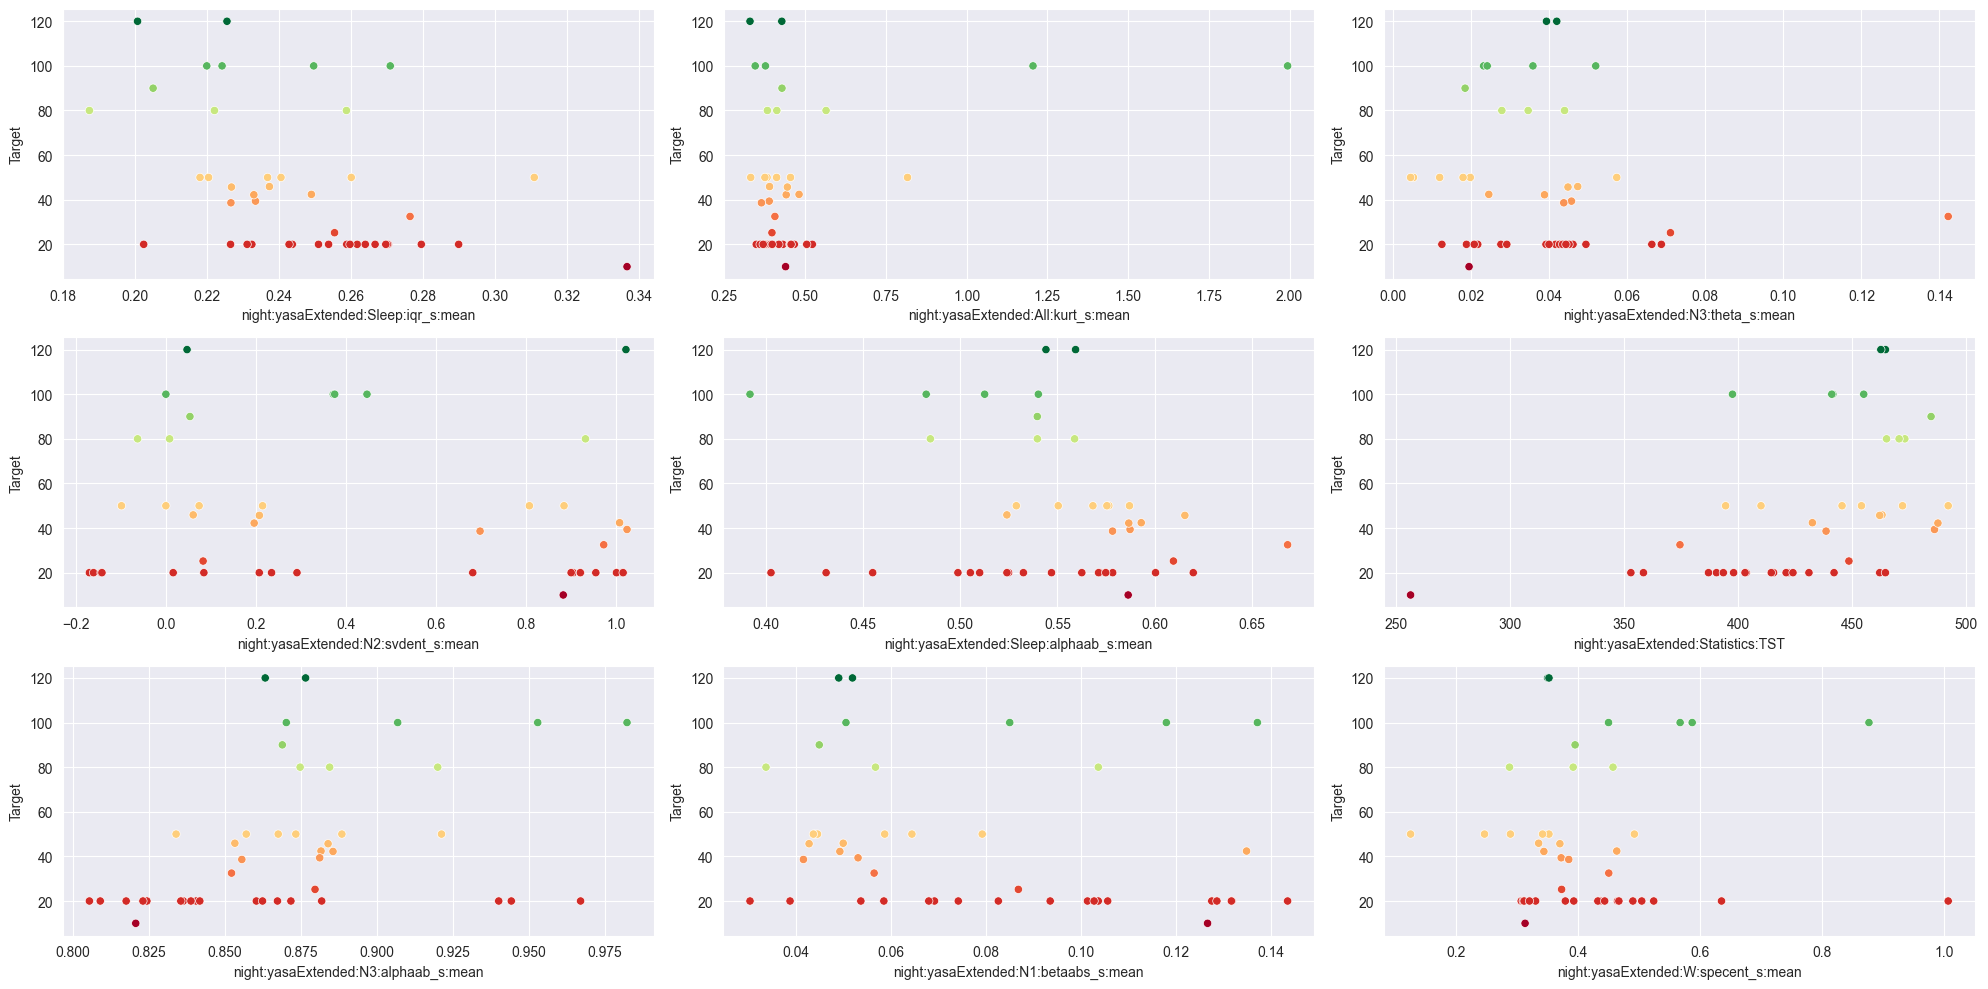

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.clf()

def evaluate_feature_importance(xgboost_model, X, y):
    importances = xgboost_model.feature_importances_
    
    # Create a DataFrame for better visualization
    feature_importances = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importances * 100
    })
    
    # Sort the DataFrame by importance
    feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
    non_zero = feature_importances[feature_importances['Importance'] > 0]

    correlations = []
    for feature in non_zero['Feature']:
        correlation = X[feature].corr(y)
        correlations.append(correlation)
    
    non_zero['Correlation'] = correlations
    display(non_zero)
    return non_zero

def plot_top_features(feature_importances, X, y, top_n=9):
    # Create a DataFrame for better visualization
    feature_importances_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': feature_importances
    })

    # Sort the DataFrame by importance and get the top N features
    top_features = feature_importances_df.sort_values(by='Importance', ascending=False).head(top_n)['Feature']

    # Set up the plot grid
    fig, axes = plt.subplots(nrows=(top_n // 3) + (top_n % 3 > 0), ncols=3, figsize=(20, 10))
    axes = axes.flatten()

    for i, feature in enumerate(top_features):
        scatter = sns.scatterplot(x=X[feature], y=y, hue=y, palette='RdYlGn', ax=axes[i])
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Target')
        scatter.legend_.remove()  # Remove the legend

    # Remove any empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


for md in modelsAndData:
    xgboost_importances = md.model.feature_importances_
    md.xg_importances = evaluate_feature_importance(md.model, md.X, md.y)
    plot_top_features(xgboost_importances, md.X, md.y)

In [49]:
modelsAndData[0].xg_importances

,Feature,Importance,Correlation
52,night:yasaExtended:Sleep:iqr_s:mean,27.368073,-0.450693
27,night:yasaExtended:All:kurt_s:mean,7.310928,0.320789
211,night:yasaExtended:N3:theta_s:mean,7.251390,-0.112429
67,night:yasaExtended:N2:svdent_s:mean,5.797981,-0.153552
193,night:yasaExtended:Sleep:alphaab_s:mean,5.413445,-0.184007
...,...,...,...
38,night:yasaExtended:All:auc_s:mean,0.000113,0.044430
36,night:yasaExtended:R:fdelta_s:mean,0.000093,0.127284
75,night:yasaExtended:R:fdeltaab_s:mean,0.000083,-0.134735
26,night:yasaExtended:All:fdeltaabs_s:mean,0.000070,-0.007956


# Linear regressor

In [39]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Initialize the Linear Regression model
linear_regressor = LinearRegression()

# Train the model
for md in modelsAndData:
    md.model_linear = linear_regressor.fit(md.X, md.y)

    # Make predictions
    y_pred_train = linear_regressor.predict(md.X)
    # y_pred_test = linear_regressor.predict(X_test)
    
    # Evaluate the model
    train_mse = mean_squared_error(md.y, y_pred_train)
    train_mae = mean_absolute_error(md.y, y_pred_train)
    # test_mse = mean_squared_error(y_test, y_pred_test)
    # test_mae = mean_absolute_error(y_test, y_pred_test)
    
    print(f"Training Mean Squared Error: {train_mse}")
    print(f"Training Mean Absolute Error: {train_mae}")
    # print(f"Testing Mean Squared Error: {test_mse}")
    # print(f"Testing Mean Absolute Error: {test_mae}")

Training Mean Squared Error: 1.7755607872304746e-23
Training Mean Absolute Error: 3.587084118111687e-12


Top 10% feature importances for model: target:energy:energyScore sources:['eeg']


,Feature,Importance,Absolute Importance
139,night:yasaExtended:SlowWaves:Aggregated:ValNeg...,-8.890042,8.890042
315,night:yasaExtended:W:kurt_s:mean,4.853953,4.853953
421,night:yasaExtended:SlowWaves:Aggregated:ValPos...,-4.848014,4.848014
387,night:yasaExtended:W:std_s:mean,4.375452,4.375452
91,night:yasaExtended:SlowWaves:Aggregated:PTP,4.027703,4.027703
218,night:yasaExtended:Statistics:SME,3.780882,3.780882
99,night:yasaExtended:N3:db_s:mean,-2.658607,2.658607
28,night:yasaExtended:Statistics:N3,2.596619,2.596619
367,night:yasaExtended:W:auc_s:mean,2.517869,2.517869
163,night:yasaExtended:W:dt_s:mean,-2.379024,2.379024


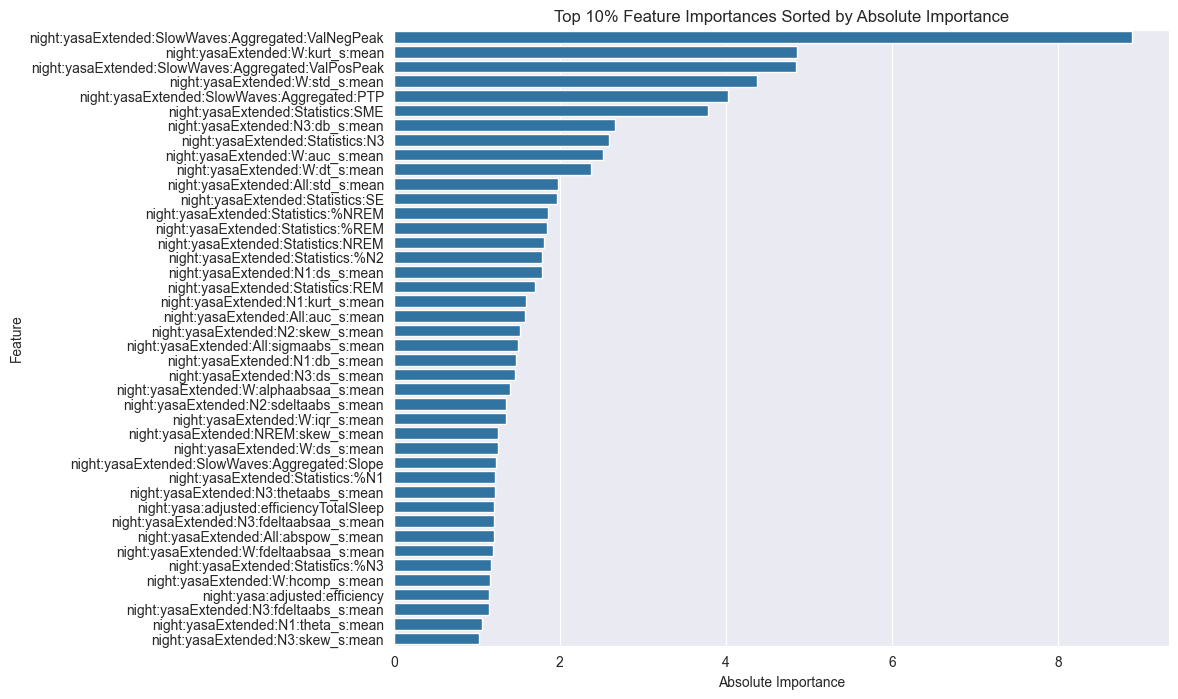

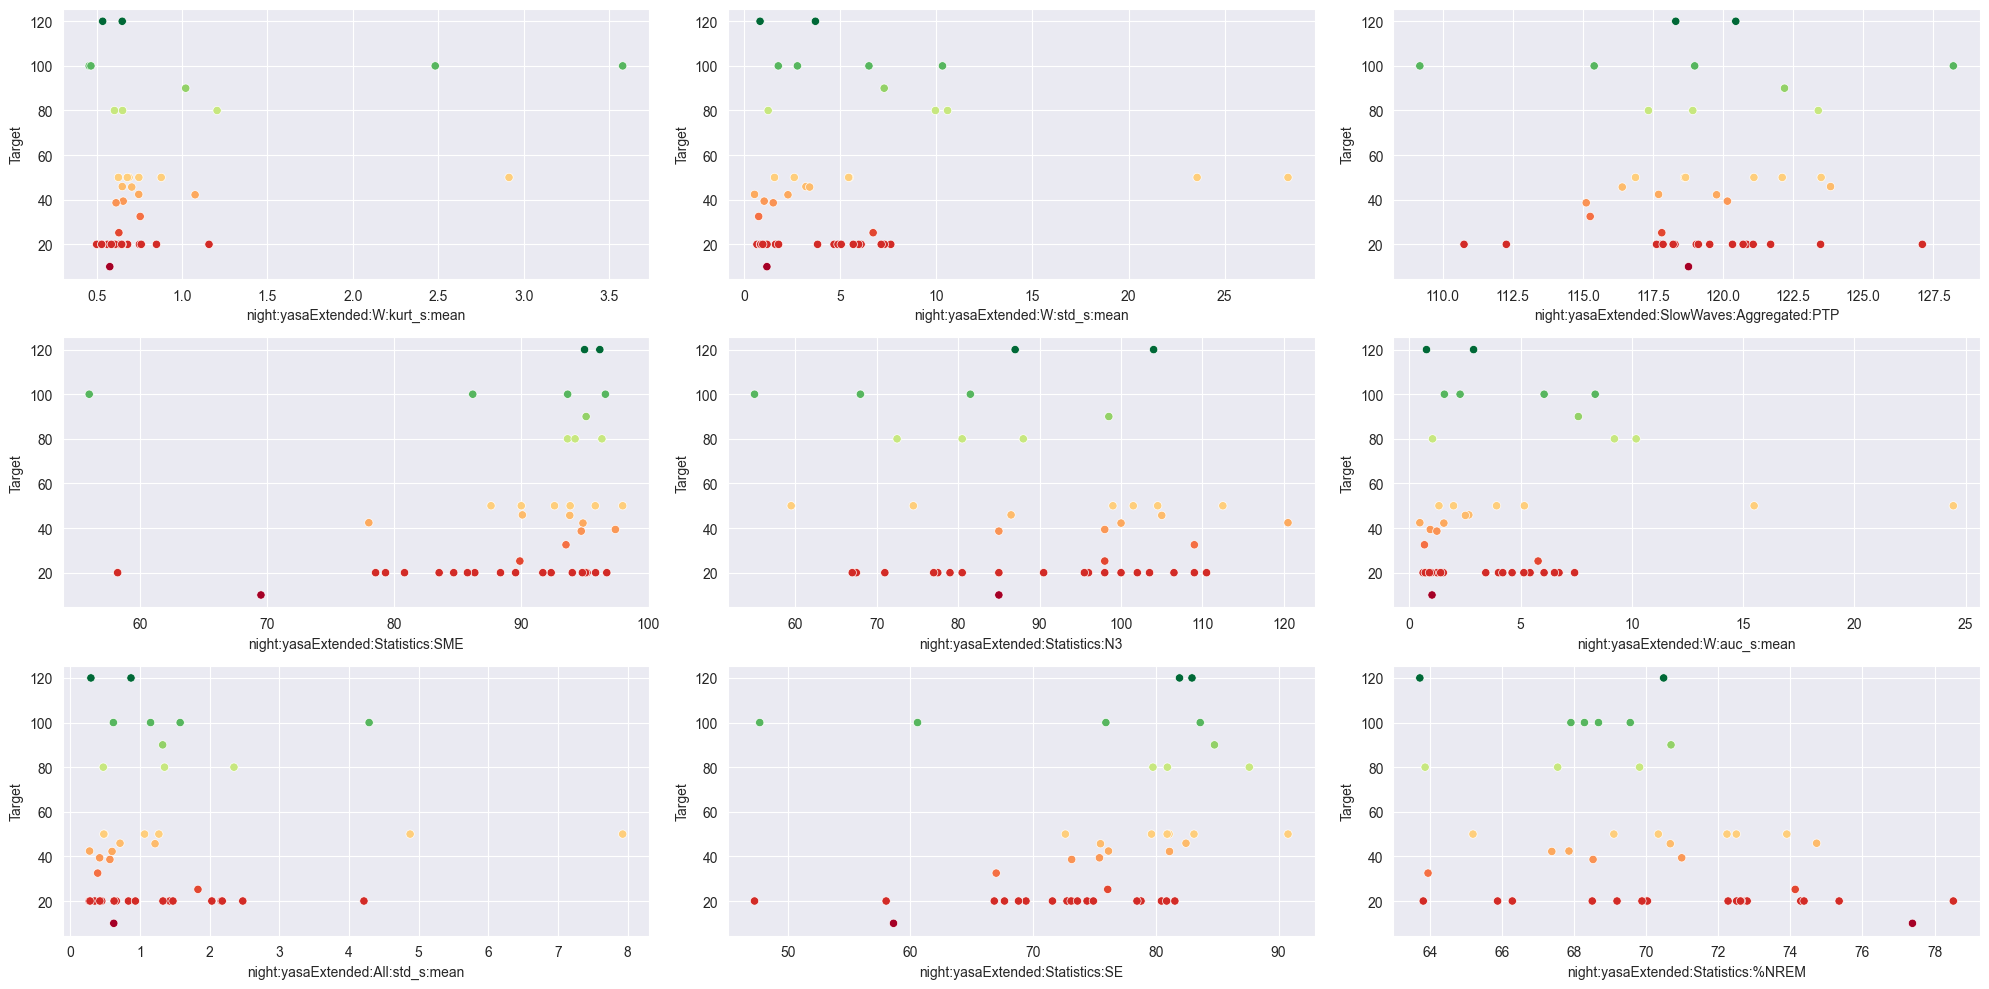

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def get_sorted_feature_importances(model, X):
    # Extract feature importances
    feature_importances = model.coef_

    # Create a DataFrame for better visualization
    feature_importances_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': feature_importances
    })

    # Sort the DataFrame by absolute importance
    feature_importances_df['Absolute Importance'] = feature_importances_df['Importance'].abs()
    feature_importances_df = feature_importances_df.sort_values(by='Absolute Importance', ascending=False)

    return feature_importances_df

def visualize_feature_importances(feature_importances_df):
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Absolute Importance', y='Feature', data=feature_importances_df)
    plt.title('Feature Importances Sorted by Absolute Importance')
    plt.show()


def get_top_10_percent_features(feature_importances_df):
    # Calculate the number of top features to select (10% of total features)
    top_n = max(1, int(len(feature_importances_df) * 0.1))

    # Sort the DataFrame by absolute importance and select the top 10% features
    top_features_df = feature_importances_df.sort_values(by='Absolute Importance', ascending=False).head(top_n)

    return top_features_df

def visualize_top_10_percent_features(feature_importances_df):
    top_features_df = get_top_10_percent_features(feature_importances_df)

    plt.figure(figsize=(10, 8))
    sns.barplot(x='Absolute Importance', y='Feature', data=top_features_df)
    plt.title('Top 10% Feature Importances Sorted by Absolute Importance')
    plt.show()

# Example usage with the linear regression model
for md in modelsAndData:
    print(f"Top 10% feature importances for model: {md.name}")
    feature_importances_df = get_sorted_feature_importances(md.model_linear, md.X)
    top_features_df = get_top_10_percent_features(feature_importances_df)
    display(top_features_df)
    visualize_top_10_percent_features(feature_importances_df)

    linear_importances = md.model_linear.coef_
    plot_top_features(linear_importances, md.X, md.y)

# Train with Catboost

In [13]:

import catboost as cb
from catboost import Pool

def train_catboost(X, y):
    # Create a Pool object
    train_pool = Pool(data=X, label=y)
    
    # Define the parameters for the CatBoost model
    params = {
        'iterations': 100,
        # 'eval_metric': 'Accuracy',    # Evaluation metric
        'depth': 6,
        'learning_rate': 0.1,
        'loss_function': 'RMSE',
        "task_type": "GPU"
        # 'reg_alpha': 5,
        # 'l2_leaf_reg': 3,  # L2 regularization term
        # 'border_count': 32  # Reducing the number of splits
    }
    
    
    # Train the model on the entire dataset
    model = cb.CatBoostRegressor(**params)
    model.fit(train_pool)

    from sklearn.feature_selection import RFE
    
    selector = RFE(model, n_features_to_select=9, step=0.05)
    selector = selector.fit(X, y)
    selected_features = X.columns[selector.support_]

    X_selected = X[selected_features]
    train_pool_selected = Pool(data=X_selected, label=y)
    model.fit(train_pool_selected)

    # Perform k-fold cross-validation
    cv_results = cb.cv(
        pool=train_pool,
        params=params,
        fold_count=5,
        shuffle=True,
        partition_random_seed=42,
        plot=True
    )

    # Print the cross-validation results
    print(cv_results)
    
    print("Selected features:", selected_features)
    return model, selected_features



In [14]:
cb_model_eeg_deep, cb_eeg_deep_selected_features = train_catboost(X_eeg_deep, y_eeg_deep)

0:	learn: 0.3574097	total: 89.4ms	remaining: 8.85s
1:	learn: 0.3521470	total: 91.8ms	remaining: 4.5s
2:	learn: 0.3483496	total: 94ms	remaining: 3.04s
3:	learn: 0.3451065	total: 96.5ms	remaining: 2.31s
4:	learn: 0.3414259	total: 98.6ms	remaining: 1.87s
5:	learn: 0.3370664	total: 101ms	remaining: 1.58s
6:	learn: 0.3335357	total: 103ms	remaining: 1.37s
7:	learn: 0.3304784	total: 105ms	remaining: 1.21s
8:	learn: 0.3263274	total: 107ms	remaining: 1.09s
9:	learn: 0.3231713	total: 110ms	remaining: 988ms
10:	learn: 0.3212071	total: 112ms	remaining: 907ms
11:	learn: 0.3180962	total: 115ms	remaining: 840ms
12:	learn: 0.3161539	total: 118ms	remaining: 790ms
13:	learn: 0.3143888	total: 121ms	remaining: 743ms
14:	learn: 0.3123148	total: 124ms	remaining: 702ms
15:	learn: 0.3101918	total: 128ms	remaining: 673ms
16:	learn: 0.3086509	total: 132ms	remaining: 644ms
17:	learn: 0.3070148	total: 135ms	remaining: 616ms
18:	learn: 0.3057195	total: 138ms	remaining: 586ms
19:	learn: 0.3042356	total: 140ms	remai

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]
0:	learn: 0.5589920	test: 0.4561579	best: 0.4561579 (0)	total: 8.95ms	remaining: 886ms
1:	learn: 0.5285798	test: 0.4241996	best: 0.4241996 (1)	total: 16ms	remaining: 783ms
2:	learn: 0.5037217	test: 0.4034228	best: 0.4034228 (2)	total: 21.8ms	remaining: 704ms
3:	learn: 0.4808720	test: 0.3840364	best: 0.3840364 (3)	total: 28.7ms	remaining: 688ms
4:	learn: 0.4600932	test: 0.3696809	best: 0.3696809 (4)	total: 33.1ms	remaining: 628ms
5:	learn: 0.4423553	test: 0.3524926	best: 0.3524926 (5)	total: 38ms	remaining: 595ms
6:	learn: 0.4264041	test: 0.3431750	best: 0.3431750 (6)	total: 43.8ms	remaining: 582ms
7:	learn: 0.4131538	test: 0.3313244	best: 0.3313244 (7)	total: 50.1ms	remaining: 576ms
8:	learn: 0.4014722	test: 0.3257034	best: 0.3257034 (8)	total: 56.8ms	remaining: 575ms
9:	learn: 0.3910002	test: 0.3259056	best: 0.3257034 (8)	total: 63ms	remaining: 567ms
10:	learn: 0.3822050	test: 0.3194134	best: 0.3194134 (10)	total: 68.7ms	remaining: 556ms
11:	learn: 0.3749485	tes

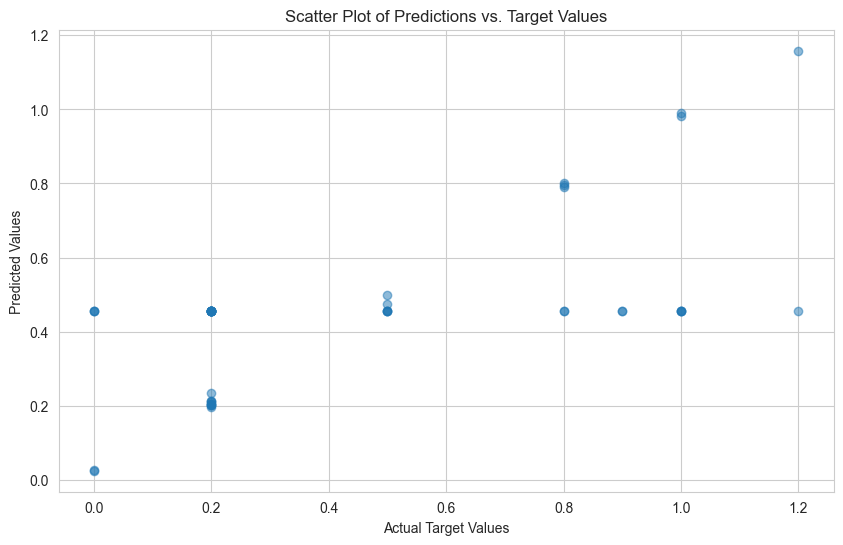

,0
count,49.000
mean,0.445
std,0.223
min,0.024
25%,0.455
50%,0.455
75%,0.455
max,1.158


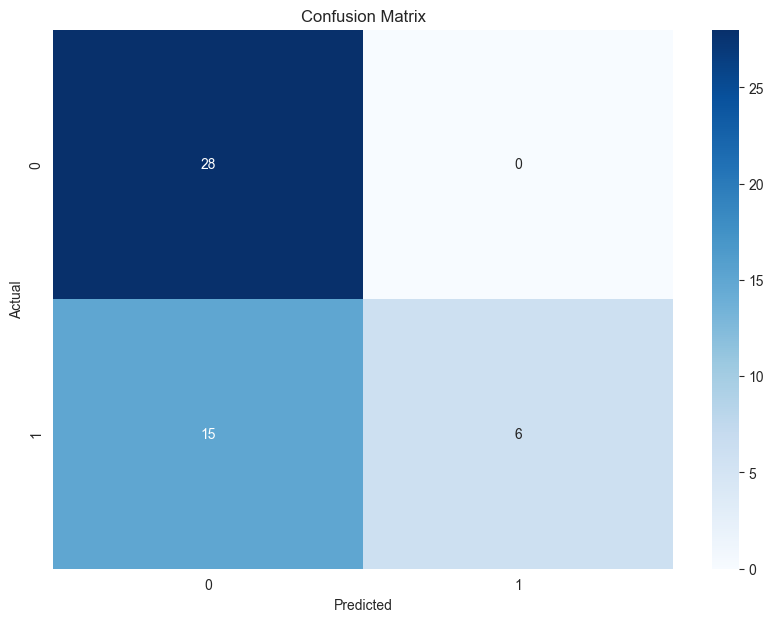

,Actual,Predicted,Diff
81,1.000,0.455,0.545
82,0.200,0.200,-0.000
85,0.800,0.455,0.345
86,1.000,0.455,0.545
87,0.200,0.455,-0.255
92,1.000,0.455,0.545
96,0.200,0.455,-0.255
97,0.200,0.455,-0.255
98,0.200,0.455,-0.255
120,1.000,0.981,0.019


,Actual,Predicted,Diff
81,1.000,0.455,0.545
82,0.200,0.200,-0.000
85,0.800,0.455,0.345
86,1.000,0.455,0.545
87,0.200,0.455,-0.255
92,1.000,0.455,0.545
96,0.200,0.455,-0.255
97,0.200,0.455,-0.255
98,0.200,0.455,-0.255
120,1.000,0.981,0.019


In [15]:
y_pred_eeg_deep = cb_model_eeg_deep.predict(X_eeg_deep)
evaluate_model(cb_model_eeg_deep, X_eeg_deep, y_eeg_deep, y_pred_eeg_deep)

,Feature,Importance,Correlation
5,night:yasaExtended:N3:specent_s:percentile10:o...,37.976,0.247
3,night:yasaExtended:N3:perment_s:percentile25:o...,23.625,0.422
7,night:yasaExtended:N3:perment_s:percentile75:o...,9.283,0.422
1,night:yasaExtended:N3:sdelta_s:percentile90:on...,8.020,0.253
6,night:yasaExtended:N3:sdelta_s:mean:onDayMinus1,6.722,0.378
4,night:yasaExtended:N3:alpha_s:percentile10:onD...,5.933,0.348
2,night:yasaExtended:Statistics:%N3:onDayMinus1,4.281,-0.215
0,night:yasaExtended:N3:at_s:percentile90:onDayM...,4.026,-0.313
8,night:yasaExtended:N3:sigma_s:percentile25:onD...,0.133,0.169


<Figure size 640x480 with 0 Axes>

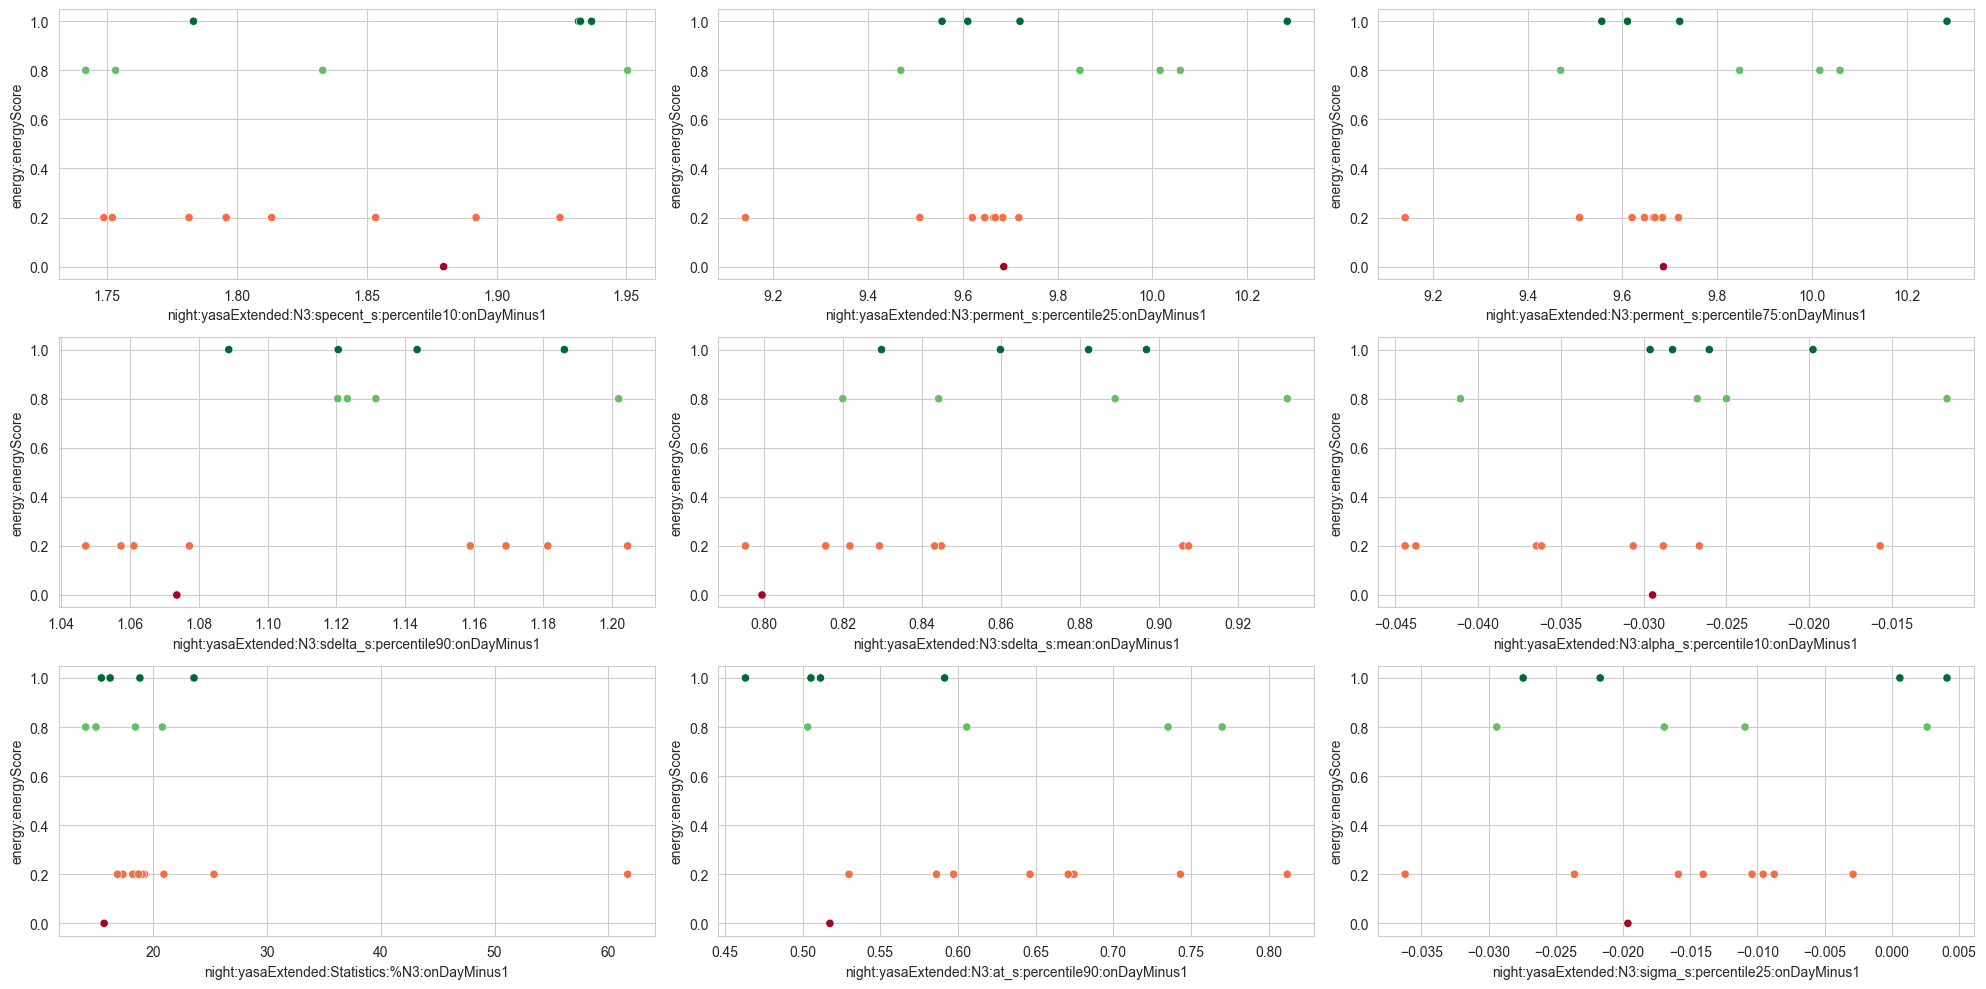

In [357]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.clf()

def evaluate_feature_importance(catboost_model, X, y, selected_features):
    importances = catboost_model.get_feature_importance()

    # Create a DataFrame for better visualization
    feature_importances = pd.DataFrame({
        'Feature': selected_features.tolist(),
        'Importance': importances
    })

    # Sort the DataFrame by importance
    feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
    non_zero = feature_importances[feature_importances['Importance'] > 0]

    correlations = []
    for feature in non_zero['Feature']:
        correlation = X[feature].corr(y)
        correlations.append(correlation)

    non_zero['Correlation'] = correlations
    display(non_zero)

def plot_top_features(catboost_model, X, y, selected_features, top_n=9):
    importances = catboost_model.get_feature_importance()

    # Create a DataFrame for better visualization
    feature_importances = pd.DataFrame({
        'Feature': selected_features.tolist(),
        'Importance': importances
    })

    # Sort the DataFrame by importance and get the top N features
    top_features = feature_importances.sort_values(by='Importance', ascending=False).head(top_n)['Feature']

    # Set up the plot grid
    fig, axes = plt.subplots(nrows=(top_n // 3) + (top_n % 3 > 0), ncols=3, figsize=(20, 10))
    axes = axes.flatten()

    for i, feature in enumerate(top_features):
        scatter = sns.scatterplot(x=X[feature], y=y, hue=y, palette='RdYlGn', ax=axes[i])
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel(target_col)
        scatter.legend_.remove()  # Remove the legend

    # Remove any empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

evaluate_feature_importance(cb_model_eeg_deep, X_eeg_deep, y_eeg_deep, cb_eeg_deep_selected_features)
plot_top_features(cb_model_eeg_deep, X_eeg_deep, y_eeg_deep, cb_eeg_deep_selected_features)

In [232]:
# cb_eeg_deep_selected_features.tolist()

['night:yasaExtended:N3:perment_s:mean:onDayMinus1',
 'night:yasaExtended:N3:dt:percentile75:onDayMinus1',
 'night:yasaExtended:N3:at_s:percentile90:onDayMinus1',
 'night:yasaExtended:N3:sdelta_s:percentile25:onDayMinus1',
 'night:yasaExtended:N3:perment:percentile10:onDayMinus1',
 'night:yasaExtended:N3:perment_s:percentile90:onDayMinus1',
 'night:yasaExtended:N3:sdelta_s:mean:onDayMinus1',
 'night:yasaExtended:N3:theta:mean:onDayMinus1',
 'night:yasaExtended:N3:sdelta:percentile25:onDayMinus1']

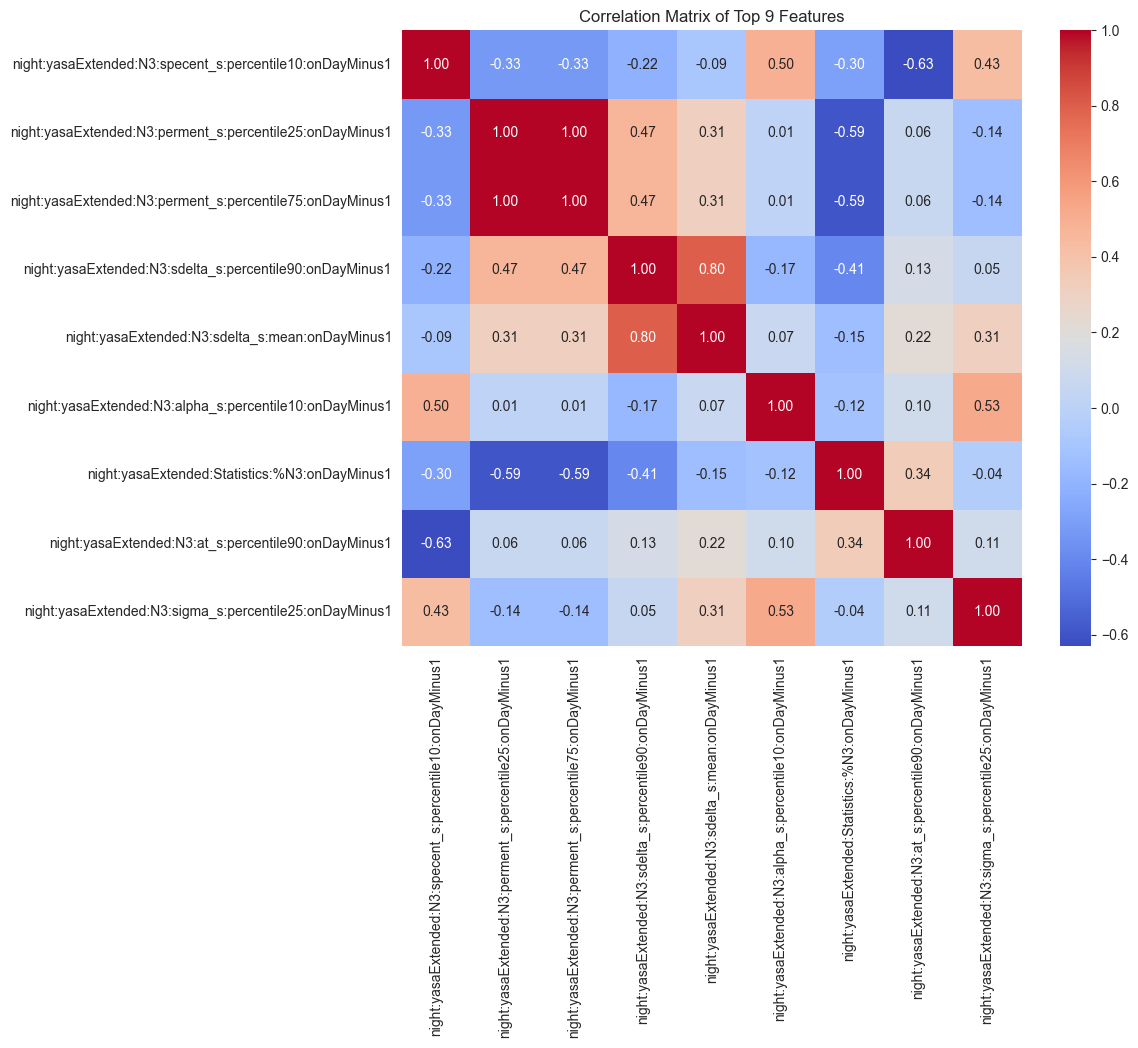

In [358]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def display_correlation_matrix(model, X, selected_features, top_n=9):
    # Extract feature importances
    importances = model.feature_importances_

    # Create a DataFrame for better visualization
    feature_importances = pd.DataFrame({
        'Feature': selected_features.tolist(),
        'Importance': importances
    })

    # Sort the DataFrame by importance and get the top N features
    top_features = feature_importances.sort_values(by='Importance', ascending=False).head(top_n)['Feature']

    # Compute the correlation matrix for the top N features
    correlation_matrix = X[top_features].corr()

    # Display the correlation matrix using a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix of Top 9 Features')
    plt.show()

# Example usage with the CatBoost model
display_correlation_matrix(cb_model_eeg_deep, X_eeg_deep, cb_eeg_deep_selected_features, top_n=9)

In [ ]:
[col for col in result_df.columns if 'deepSleep' in col]

In [ ]:
[col for col in X_eeg_deep.columns if 'deepSleep' in col]

In [320]:
cb_model_all_features, cb_all_selected_features = train_catboost(X_all_features, y_all_features)


0:	learn: 0.3305038	total: 7.83ms	remaining: 775ms
1:	learn: 0.3164058	total: 13.3ms	remaining: 651ms
2:	learn: 0.3037111	total: 19ms	remaining: 616ms
3:	learn: 0.2922081	total: 24.8ms	remaining: 595ms
4:	learn: 0.2798137	total: 30.6ms	remaining: 581ms
5:	learn: 0.2689542	total: 36.3ms	remaining: 569ms
6:	learn: 0.2557845	total: 41.7ms	remaining: 554ms
7:	learn: 0.2456802	total: 48.3ms	remaining: 555ms
8:	learn: 0.2367317	total: 55.2ms	remaining: 558ms
9:	learn: 0.2262467	total: 61.2ms	remaining: 551ms
10:	learn: 0.2179696	total: 69.1ms	remaining: 559ms
11:	learn: 0.2100975	total: 74.9ms	remaining: 549ms
12:	learn: 0.2007182	total: 80.7ms	remaining: 540ms
13:	learn: 0.1931335	total: 86.8ms	remaining: 533ms
14:	learn: 0.1849558	total: 92.7ms	remaining: 525ms
15:	learn: 0.1773469	total: 98.5ms	remaining: 517ms
16:	learn: 0.1705974	total: 104ms	remaining: 508ms
17:	learn: 0.1642658	total: 112ms	remaining: 510ms
18:	learn: 0.1589740	total: 119ms	remaining: 508ms
19:	learn: 0.1522031	total:

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]
0:	learn: 0.5364903	test: 0.4896586	best: 0.4896586 (0)	total: 19.6ms	remaining: 1.94s
1:	learn: 0.5064654	test: 0.4829219	best: 0.4829219 (1)	total: 43.4ms	remaining: 2.13s
2:	learn: 0.4732481	test: 0.4648311	best: 0.4648311 (2)	total: 60.8ms	remaining: 1.96s
3:	learn: 0.4490412	test: 0.4532840	best: 0.4532840 (3)	total: 73.1ms	remaining: 1.75s
4:	learn: 0.4257557	test: 0.4451479	best: 0.4451479 (4)	total: 86.1ms	remaining: 1.64s
5:	learn: 0.3987898	test: 0.4298060	best: 0.4298060 (5)	total: 98.6ms	remaining: 1.54s
6:	learn: 0.3772568	test: 0.4233793	best: 0.4233793 (6)	total: 111ms	remaining: 1.48s
7:	learn: 0.3523018	test: 0.4220114	best: 0.4220114 (7)	total: 126ms	remaining: 1.45s
8:	learn: 0.3305037	test: 0.4192520	best: 0.4192520 (8)	total: 145ms	remaining: 1.47s
9:	learn: 0.3106772	test: 0.4108852	best: 0.4108852 (9)	total: 158ms	remaining: 1.42s
10:	learn: 0.2920905	test: 0.4033327	best: 0.4033327 (10)	total: 171ms	remaining: 1.38s
11:	learn: 0.2776362	te

In [321]:
cb_all_selected_features.tolist()

['night:aggregated:betweenReadyToSleepAndAsleepSecs:onDayMinus1',
 'night:fitbit:adjusted:betweenReadyToSleepAndAsleepSecs:onDayMinus1',
 'night:fitbit:adjusted:wakingsWithDurationCount:onDayMinus1',
 'night:aggregated:totalSleepTimeSecs:onDayMinus1',
 'night:fitbit:adjusted:timeAwakeAfterSleepSecs:onDayMinus1',
 'drugsAndSupplements:RitalinLastSSM:onDayMinus1',
 'hr:ReadyToSleepToMiddleOfSleep:percentile90:onDayMinus1',
 'night:yasaExtended:N1:perment:percentile75:onDayMinus1',
 'circadian:combined:entries:LEP:minsUntilWake:onDayMinus1']

In [322]:
y_pred_all_features = cb_model_all_features.predict(X_all_features)


,Feature,Importance,Correlation
0,night:aggregated:betweenReadyToSleepAndAsleepS...,19.449,-0.234
3,night:aggregated:totalSleepTimeSecs:onDayMinus1,15.007,-0.500
6,hr:ReadyToSleepToMiddleOfSleep:percentile90:on...,13.922,0.170
5,drugsAndSupplements:RitalinLastSSM:onDayMinus1,11.407,0.213
4,night:fitbit:adjusted:timeAwakeAfterSleepSecs:...,11.242,0.217
2,night:fitbit:adjusted:wakingsWithDurationCount...,9.834,0.005
1,night:fitbit:adjusted:betweenReadyToSleepAndAs...,7.253,-0.078
8,circadian:combined:entries:LEP:minsUntilWake:o...,6.245,0.518
7,night:yasaExtended:N1:perment:percentile75:onD...,5.642,0.432


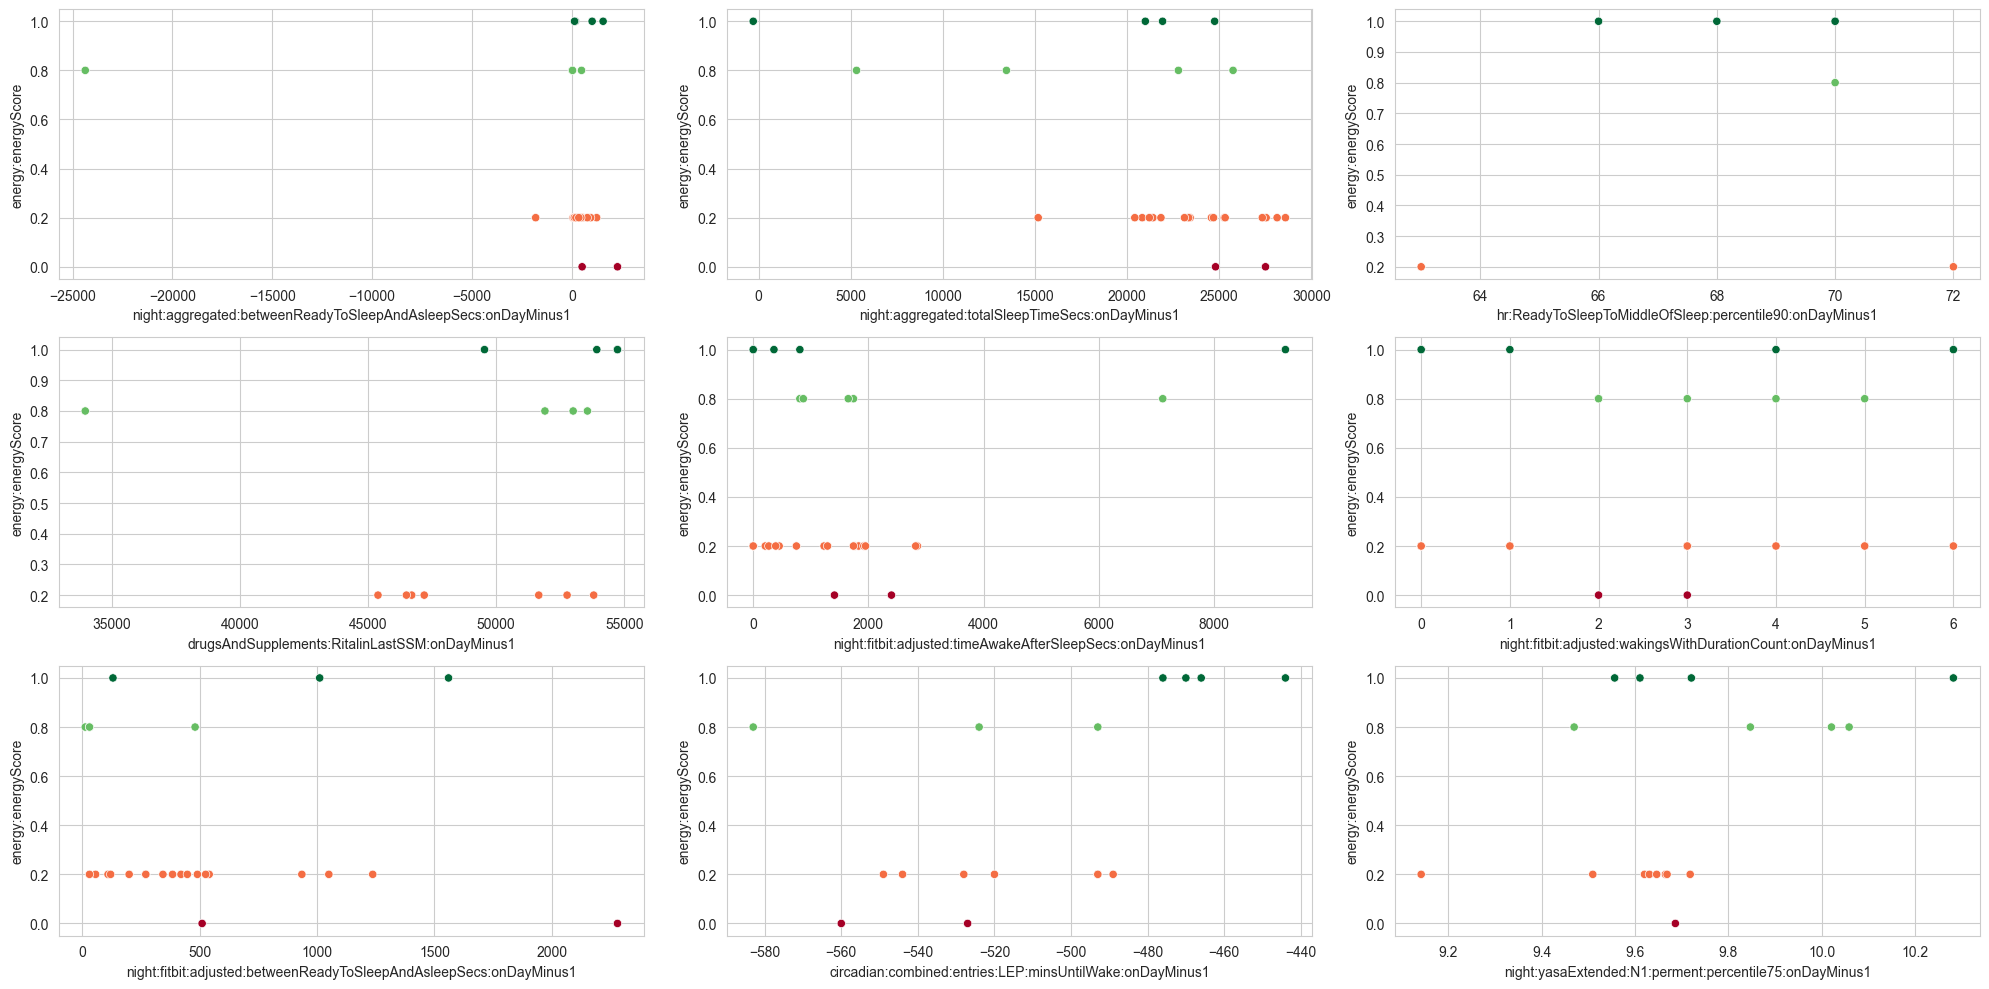

In [323]:

evaluate_feature_importance(cb_model_all_features, X_all_features, y_all_features, cb_all_selected_features)
plot_top_features(cb_model_all_features, X_all_features, y_all_features, cb_all_selected_features)

In [324]:
df_before_night = prepared_df_before_night.copy()
df_before_night["EnergyPredictionFromEEGDeep"] = y_pred_eeg_deep
df_before_night["EnergyPredictionFromAllFeatures"] = y_pred_all_features
df_before_night[["energy:energyScore", "EnergyPredictionFromEEGDeep", "EnergyPredictionFromAllFeatures"]]

,energy:energyScore,EnergyPredictionFromEEGDeep,EnergyPredictionFromAllFeatures
81,1.000,0.364,0.974
82,0.200,0.209,0.201
85,0.800,0.797,0.777
86,1.000,0.989,0.992
87,0.200,0.202,0.206
92,1.000,0.972,0.987
96,0.200,0.364,0.240
97,0.200,0.199,0.194
98,0.200,0.204,0.198
120,1.000,0.993,0.973


In [326]:
numerical_df = df_before_night.select_dtypes(include=['number'])
corr =  numerical_df.corr()
correlation_matrix_from_eeg_deep = corr['EnergyPredictionFromEEGDeep']
correlation_matrix_from_all_features = corr['EnergyPredictionFromAllFeatures']
correlation_matrix_from_all_features
# 
# # Compute the correlation matrix
# correlation_matrix = numerical_df.corr().abs()
# mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
# 
# # Apply the mask to the correlation matrix
# masked_corr_matrix = correlation_matrix.mask(mask)

# Find the pairs of features with correlation above 95%
# high_corr_pairs = masked_corr_matrix.stack().reset_index()
# high_corr_pairs.columns = ['Feature1', 'Feature2', 'Correlation']
# high_corr_pairs = high_corr_pairs[high_corr_pairs['Correlation'] > 0.95]
# 
# non_null_matrix = numerical_df.notnull().astype(int)
# 
# # Use matrix multiplication to count non-null pairs
# non_null_counts = non_null_matrix.T.dot(non_null_matrix)
# 
# out_df = df_before_night.copy()
# # Extract the counts for the high correlation pairs
# out_df['NonNullCount'] = out_df.apply(
#     lambda row: non_null_counts.loc[row['Feature1'], row['Feature2']], axis=1
# )


drugsAndSupplements:drugsAndSupplementsCount:onDayMinus1    0.143
date:year:onDayMinus1                                         NaN
exercise:fitbit:elevation:onDayMinus1                      -0.074
exercise:fitbit:heartRateZonesCount:onDayMinus1            -0.290
events:sex:count:onDayMinus1                               -0.216
                                                            ...  
coreBodyTemp:GotIntoBedToAwake:percentile90:onDayMinus1     0.096
drugsAndSupplements:ElvanseLastSSM:onDayMinus1             -0.595
drugsAndSupplements:ElvanseQuantity:onDayMinus1             0.354
EnergyPredictionFromEEGDeep                                 0.814
EnergyPredictionFromAllFeatures                             1.000
Name: EnergyPredictionFromAllFeatures, Length: 264, dtype: float64

In [312]:
# sns.scatterplot(x='drugsAndSupplements:ElvanseQuantity:onDayMinus1', y='EnergyPredictionFromEEGDeep', alpha=0.5, data=df_before_night)
# # 

<Axes: xlabel='sunExposure:firstDurationOutsideSecs:onDayMinus1', ylabel='energy:energyScore'>

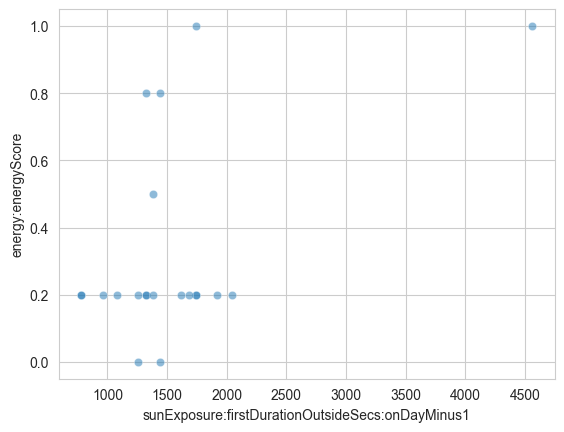

In [329]:
sns.scatterplot(x='sunExposure:firstDurationOutsideSecs:onDayMinus1', y='energy:energyScore', alpha=0.5, data=df_before_night)


In [338]:
corr_result_df = result_df.select_dtypes(include=['number']).corr()

In [339]:
corr_result_df["night.aggregated.awakeAfterSleepSecs"]

presence:presence:aggregated:graham_study:totalDurationSecs      NaN
presence:presence:aggregated:bedroom:totalDurationSecs           NaN
date:daysSince                                                   NaN
sunrise:sunsetDurationSecs                                    -0.019
presence:devices:aggregated:Work:firstUsedSSM                    NaN
                                                               ...  
events:finishedOwnWork:count:vsDayMinus1                         NaN
events:finishedOwnWork:lastSSM:onDayMinus1                       NaN
events:finishedOwnWork:firstSSM:vsDayMinus1                      NaN
events:finishedOwnWork:firstSSM:onDayMinus1                      NaN
events:finishedOwnWork:lastSSM:vsDayMinus1                       NaN
Name: night.aggregated.awakeAfterSleepSecs, Length: 10461, dtype: float64

In [331]:
[col for col in result_df.columns if 'awakeAfter' in col]

['night:aggregated:awakeAfterSleepSecs',
 'night.aggregated.awakeAfterSleepSecs',
 'night:aggregated:awakeAfterSleepSecs:vsDayMinus1',
 'night.awakeAfterSleepMillis',
 'night:aggregated:awakeAfterSleepSecs:onDayMinus1',
 'night:yasa:source:awakeAfterSleepSecs',
 'night:nightEvents:awakeAfterSleep',
 'night:fitbit:source:awakeAfterSleepSecs',
 'night:fitbit:adjusted:awakeAfterSleepSecs']

<Axes: xlabel='food:aggregated:totalCaffeineMg', ylabel='night.aggregated.awakeAfterSleepSecs'>

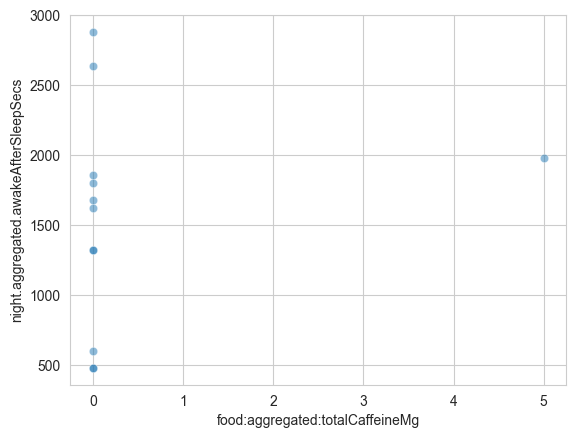

In [349]:
sns.scatterplot(x='food:aggregated:totalCaffeineMg', y='night.aggregated.awakeAfterSleepSecs', alpha=0.5, data=result_df)


In [345]:
[col for col in result_df.columns if 'Concerta' in col]


['drugsAndSupplements:ConcertaXLQuantity',
 'drugsAndSupplements:ConcertaXLLastSSM',
 'drugsAndSupplements:ConcertaXLLastSSM:onDayMinus1',
 'drugsAndSupplements:ConcertaXLQuantity:vsDayMinus1',
 'drugsAndSupplements:ConcertaXLQuantity:onDayMinus1',
 'drugsAndSupplements:ConcertaXLLastSSM:vsDayMinus1']

In [298]:
[col for col in df_before_night.columns if 'Elvanse' in col]


['drugsAndSupplements:totalElvanseCountMg',
 'drugsAndSupplements:totalElvanseCountMg:vsDayMinus1',
 'drugsAndSupplements:ElvanseLastSSM',
 'drugsAndSupplements:ElvanseQuantity',
 'drugsAndSupplements:ElvanseQuantity:vsDayMinus1',
 'drugsAndSupplements:ElvanseLastSSM:vsDayMinus1']